#### System specifications on which experiments were run!!! Ram-> 4GB, Core i5

# Exercise 0: Dataset Preprocessing

## Importing Libraries

In [642]:
import pandas as pd
import numpy as np
from sklearn import neighbors
import math
import warnings
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore")

### Function that return different statistics about dataset and check if has missing values\ unequal length.

In [632]:
def merge_and_split(train_path, test_path, dataset_path):
#     print("Processing " ,dataset_path.split("\\")[-1])

    df_train = pd.read_csv(train_path,sep='\t', header=None)
    df_test = pd.read_csv(test_path,sep='\t', header=None)
    df_full = df_train.append(df_test)
    
    miss_value_dataset = df_full.isnull().values.any()

    return dataset_path.split("\\")[-1], df_full.shape[1]-1, len(np.unique(df_full.iloc[:,0])), df_full.shape[0],miss_value_dataset

### Load all datasets in repository and get different statistics about each dataset. Also get list of datasets having missing value or unequal length.

In [633]:
path = "./UCRArchive_2018"
dir_list = os.listdir(path) 
DatasetNames = []
DatasetLength=[]
DatasetClasses = []
DatasetSamples=[]
MissingValuesDatasets = []

dir_list.remove("Missing_value_and_variable_length_datasets_adjusted")
for datasets_name in dir_list:
    full_dataset_path = os.path.join(path,datasets_name)
    datasets = [f for f in os.listdir(full_dataset_path) if not f.startswith('.')]
    datasets.remove("README.md")
    train_path = full_dataset_path + "\\"+ full_dataset_path.split("\\")[-1] + "_TRAIN.tsv"
    test_path = full_dataset_path + "\\" + full_dataset_path.split("\\")[-1] + "_TEST.tsv"

    name, length,classes, sample, missvalueDatasets = merge_and_split(train_path, test_path,full_dataset_path)
    DatasetNames.append(name)
    DatasetLength.append(length)
    DatasetClasses.append(classes)
    DatasetSamples.append(sample)
    if missvalueDatasets:
        MissingValuesDatasets.append(name)

### Interesting Statistics

In [641]:
stats = pd.DataFrame({"Dataset Name":DatasetNames, "Length":DatasetLength, "Total Classes":DatasetClasses, "Total Samples":DatasetSamples })
stats

,Dataset Name,Length,Total Classes,Total Samples
0,ACSF1,1460,10,200
1,Adiac,176,37,781
2,AllGestureWiimoteX,500,10,1000
3,AllGestureWiimoteY,500,10,1000
4,AllGestureWiimoteZ,500,10,1000
...,...,...,...,...
123,Wine,234,2,111
124,WordSynonyms,270,25,905
125,Worms,900,5,258
126,WormsTwoClass,900,2,258


#### It was not possible to plot the interesting Statistics of all the datasets. So I plotted the results of first 10 datasets. You can see the statistics of all the datasets in above dataframe

### Plot indicating the total the length of samples.

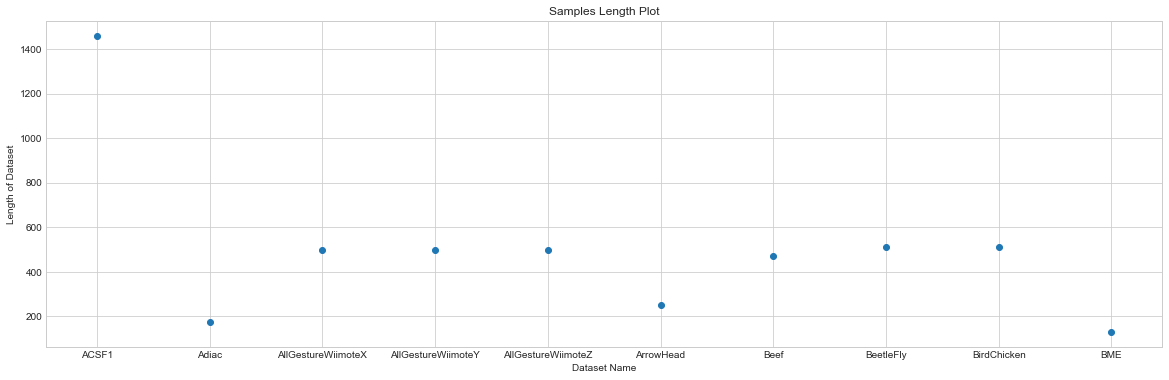

In [649]:
plt.gcf().set_size_inches(20, 6)
plt.subplot(1, 1, 1)
plt.title('Samples Length Plot')
plt.scatter(DatasetNames[:10], DatasetLength[:10])
plt.xlabel("Dataset Name")
plt.ylabel("Length of Dataset");

### Plot indicating number of classes

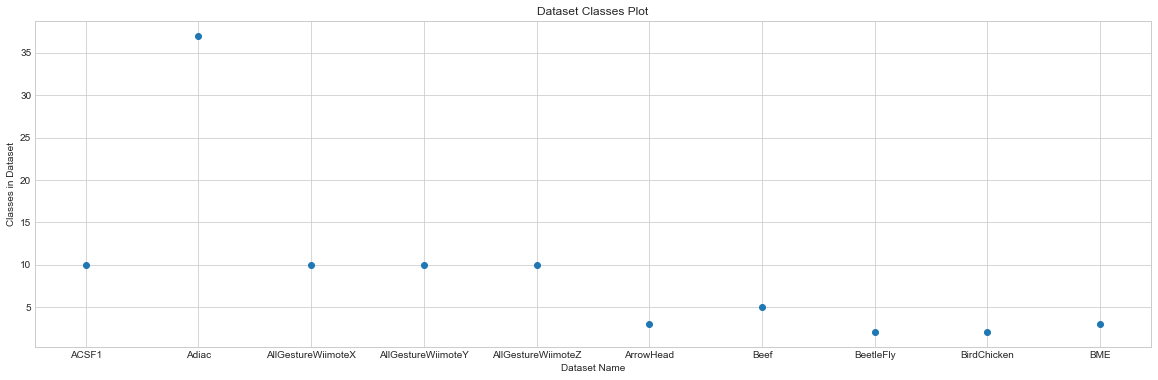

In [650]:
plt.gcf().set_size_inches(20, 6)
plt.subplot(1, 1, 1)
plt.title('Dataset Classes Plot')
plt.scatter(DatasetNames[:10], DatasetClasses[:10])
plt.xlabel("Dataset Name")
plt.ylabel("Classes in Dataset");

### Plot indicating number of samples

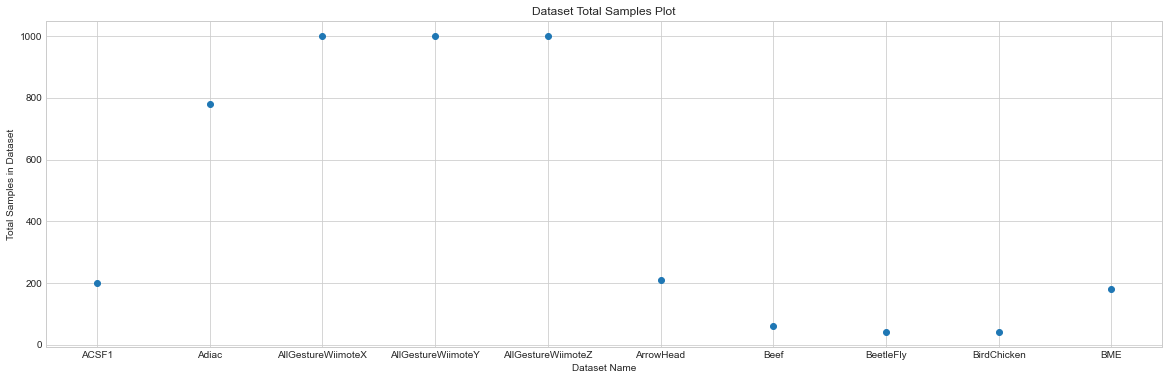

In [651]:
plt.gcf().set_size_inches(20, 6)
plt.subplot(1, 1, 1)
plt.title('Dataset Total Samples Plot')
plt.scatter(DatasetNames[:10], DatasetSamples[:10])
plt.xlabel("Dataset Name")
plt.ylabel("Total Samples in Dataset");

## Dataset having largest number of samples. We will work with this dataset in exercise 3

In [652]:
DatasetNames[np.argsort(DatasetSamples)[-3:][::-1][0]]

'Crop'

### Now we will preprocess datasets having missing values or unequal lengths

In [654]:
MissingValuesDatasets

['AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'MelbournePedestrian',
 'PickupGestureWiimoteZ',
 'PLAID',
 'ShakeGestureWiimoteZ']

In [660]:
missing_values_or_varylength_dataset = ["MelbournePedestrian","GestureMidAirD2", "DodgerLoopDay", "DodgerLoopWeekend", 
                                        "DodgerLoopGame", "AllGestureWiimoteX","AllGestureWiimoteY", "AllGestureWiimoteZ", 
                                        "PickupGestureWiimoteZ","ShakeGestureWiimoteZ", "PLAID", "GesturePebbleZ1", 
                                        "GesturePebbleZ2", "GestureMidAirD1","GestureMidAirD3"]

In [667]:
Dataset_with_missing_values = [] # lIST TO SAVE MISSING VALUES DATASET AFTER  PADING THE SAMPLES WITH 0'S ON THE LEFT.

for dst in missing_values_or_varylength_dataset:
    train_pt = "./UCRArchive_2018\\" + dst + "\\"+ dst + "_TRAIN.tsv"
    test_pt = "./UCRArchive_2018\\" + dst + "\\"+ dst + "_TEST.tsv"
    df_train = pd.read_csv(train_pt,sep='\t', header=None)
    df_test = pd.read_csv(test_pt,sep='\t', header=None)
    df_full = df_train.append(df_test)
    df_train = df_full.iloc[:,1:]
    df_test = df_full.iloc[:,0]
    
    ### GET THE LAST NON NAN VALUE INDEX, SUBTRACT IT FROM TOTAL COLUMNS AND SHIFT THE ROW VALUES THAT MANY TIMES 
    ### AND PAD 0'S ON LEFT
    max_col = df_train.shape[1]
    for i in range(df_train.shape[0]):
        last_non_nan = df_train.iloc[i,:].last_valid_index()
        shift_vals  = max_col - last_non_nan
        df_train.iloc[i]= df_train.iloc[i,:].shift(periods = shift_vals, axis=0,fill_value=0)
    
    if np.isnan(df_train.values).any(): ### CHECK IF STILL AFTER PADDING 0'S ON LEFT, THERE IS MISSING VALUES IN DATASET OR NOT
        Dataset_with_missing_values.append(dst)
    

### List of datasets having missing values.

In [669]:
Dataset_with_missing_values

['MelbournePedestrian', 'DodgerLoopDay', 'DodgerLoopWeekend', 'DodgerLoopGame']

<p>Above is list of datasets having missing values before normalizing dataset. But, if we do normalize the datasets before padding 0's to the left , then we get three additional datasets "AllGestureWiimoteY, PickupGestureWiimoteZ, ShakeGestureWiimoteZ " that have missing values. As, it was not mentioned in the lab that we need to do normalization before or after padding the 0's, so I pad 0's to the left before normalizing dataset. So I got only four datasets that have missing values which are shown above. </p>

# Exercise 1

#### List of datasets having missing values.

In [670]:
Dataset_with_missing_values

['MelbournePedestrian', 'DodgerLoopDay', 'DodgerLoopWeekend', 'DodgerLoopGame']

### Function to split the dataset into train, test and validation sets

In [672]:
def split(df,targetcol):
    
    X = df
    Y = targetcol 
    X_copy = X.copy()
    
    Xtrain = X_copy.sample(frac=0.70, random_state=0)
    Xtest = X_copy.drop(Xtrain.index)
    Xtest_copy = Xtest.copy()
    Xtest = Xtest_copy.sample(frac=0.50, random_state=1)
    Xvalidate = Xtest_copy.drop(Xtest.index)
    norm_Xtrain = np.linalg.norm(Xtrain, axis = 1, keepdims = True)
    Xtrain = Xtrain / norm_Xtrain
    norm_Xtest = np.linalg.norm(Xtest, axis = 1, keepdims = True)
    Xtest = Xtest / norm_Xtest
    norm_Xval = np.linalg.norm(Xvalidate, axis = 1, keepdims = True)
    Xval = Xvalidate / norm_Xval
    Y_copy = Y.copy()
    Ytrain = Y_copy.sample(frac=0.70, random_state=0)
    Ytest = Y_copy.drop(Ytrain.index)
    Ytest_copy = Ytest.copy()
    Ytest = Ytest_copy.sample(frac=0.50, random_state=1)
    Yvalidate = Ytest_copy.drop(Ytest.index)
    Ytrain = np.matrix(Ytrain)
    Ytest = np.matrix(Ytest)
    Yval = np.matrix(Yvalidate)
    
    return Xtrain, Ytrain, Xval, Yval, Xtest, Ytest

### Function to calculate the euclidean distance

In [673]:
def eucl_dist2(a , b):
    distance = np.sum(np.square(a-b),axis=1)
    return np.sqrt(distance)

In [680]:
def eucl_dist(a , b):
    distance = np.sum(np.square(a-b))
    return np.sqrt(distance)

### Function that will impute the missing values with the the mean of its nearest K neighbors

In [681]:
def replace_missing_values_Knn(df_train, k):
    X = df_train.copy()
    X = X.dropna(axis='columns')

    for i, row in X.iterrows():
        
        if df_train.iloc[i,:].isnull().values.any():        
            unique_id = i
            other_rows = X[~X.index.isin([i])]
            res = eucl_dist2(X, row)
            srt = np.argsort(res)[1:k+1]
            replacesment = np.mean(res[srt])
            df_train.iloc[i,:].fillna(replacesment, inplace=True)

    return df_train

### Function to calculate the k- nearest distances of query with training dataset.

In [682]:
def best_nn(df , query , k):
    distance =[]    
    if k > df.shape[0]:
        k = df.shape[0]
        
    distance = eucl_dist2(df, query)    
    agg = np.argsort(distance)[:k]
    return agg

### Function to  calculate k-neareast neighbours and do majority voting to get final prediction

In [678]:
def prediction(x , y , query, k):
    predictions = []
    
    for index,row1 in query.iterrows():
        k_min = best_nn(x , row1 , k)
        m = y[k_min].tolist()
        predictions.append(max(m , key=m.count))
    return predictions

### Function to get accuracy on specific dataset

In [726]:
def accuracy(a , p):
    count = 0
    for i ,j in zip(a , p):
        if (i == j):
            count += 1
    return (count/a.shape[0]) * 100

### Main Function

In [727]:
for ds in Dataset_with_missing_values:
    
    train_pt = "./UCRArchive_2018\\" + ds + "\\"+ ds + "_TRAIN.tsv"
    test_pt = "./UCRArchive_2018\\" + ds + "\\"+ ds + "_TEST.tsv"
    df_train = pd.read_csv(train_pt, sep='\t', header=None)
    df_test = pd.read_csv(test_pt, sep='\t', header=None)
    df_full = df_train.append(df_test)
    df_full.reset_index(drop=True, inplace=True)
    df_train = df_full.iloc[:,1:]
    df_test = df_full.iloc[:,0]
    
    ### Pad the samples with 0s on the left to make it equal length sample!!!!
    max_col = df_train.shape[1] 
    for i in range(df_train.shape[0]):
        last_non_nan = df_train.iloc[i,:].last_valid_index()
        shift_vals  = max_col - last_non_nan
        df_train.iloc[i]= df_train.iloc[i,:].shift(periods = shift_vals, axis=0,fill_value=0)


    print("##############################################--",ds," Dataset--\n")
    print("Full Dataset Shape ",df_full.shape )
    print( "Check if dataset has null values or missing values!!! ",np.isnan(df_train.values).any()) 
    print("\nK-nearest neighbour started!!!")

    listAccr = np.zeros((10,10)) # I have take k range from 1 to 10 for both imputing missing value and prediction in grid search!!!

    for k1 in range(1,10): # grid search to get best k for doing prediction
        for k2 in range(1,10): # grid search to get best k for imputing
            df_train_updated = replace_missing_values_Knn(df_train,k2) # function to impute missing values using knn 

            Xtrain, Ytrain, Xval, Yval, Xtest, Ytest = split(df_train_updated,df_test) # After replacing missing values do,
                                                                                       # the spliting on updated training dataset
            pred = prediction(Xtrain, np.array(Ytrain)[0], Xval, k1)
            listAccr[k1,k2] = accuracy(np.array(Yval)[0], pred)
        print("Done for prediction k: ", k1)

    print("K-nearest neighbour finished!!!")
    print("Final validation accuracies after grid search '(x-axis index - k used for prediction, y-xis index- k used for imputing!!!)'\n")
    print(listAccr[1:,1:])

    indx = np.unravel_index(np.nanargmax(listAccr), listAccr.shape) # get maximum accuracy index

    print("\n Optimal K for prediction: ",indx[0], " , Optimal K for imputing missing values: ", indx[1])

    print("\nCalculating test accuracy by using optimal k values for both imputing missing value and prediction task!!!")
    
    ### Now do prediction on test set with optimal paramters!!!

    df_train_updated = replaceKnn(df_train,indx[1])

    Xtrain0, Ytrain0, Xval0, Yval0, Xtest0, Ytest0 = split(df_train_updated,df_test)

    pred = prediction(Xtrain0, np.array(Ytrain0)[0], Xtest0, indx[0])

    print("\nFinal accuracy on test data: ", accuracy(np.array(Ytest0)[0], pred))
    print("--",ds," Dataset--##############################################\n")

##############################################-- MelbournePedestrian  Dataset--

Full Dataset Shape  (3633, 25)
Check if dataset has null values or missing values!!!  True

K-nearest neighbour started!!!
Done for prediction k:  1
Done for prediction k:  2
Done for prediction k:  3
Done for prediction k:  4
Done for prediction k:  5
Done for prediction k:  6
Done for prediction k:  7
Done for prediction k:  8
Done for prediction k:  9
K-nearest neighbour finished!!!
Final validation accuracies after grid search '(x-axis index - k used for prediction, y-xis index- k used for imputing!!!)'

[[88.62385321 88.62385321 88.62385321 88.62385321 88.62385321 88.62385321
  88.62385321 88.62385321 88.62385321]
 [88.62385321 88.62385321 88.62385321 88.62385321 88.62385321 88.62385321
  88.62385321 88.62385321 88.62385321]
 [89.17431193 89.17431193 89.17431193 89.17431193 89.17431193 89.17431193
  89.17431193 89.17431193 89.17431193]
 [89.35779817 89.35779817 89.35779817 89.35779817 89.35779817 89.3